This notebook uses linear regression to predict the gross revenue of theater ticket and disc sales of independent movies during the years of 2008 through 2017.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

## other

In [3]:
import scipy.stats as stats

# Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

# Custom Functions

## Model Evaluation Function
Function to create evaluation plots given test input

In [33]:
def lr_eval(model, X, y):
    '''
    Plot model accuracy, residuals and probability plots
    model : fitted model to evaluate
    X : test feature data
    y : test target data
    '''
    
    # output r squared score for model
    print('R-squared:', model.score(X, y))
    
    # cacluate model residuals
    predictions = model.predict(X)
    residuals = y - predictions
    
    # evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7, 20))
    ax1.scatter(y, predictions)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Predicted Value')
    ax2.scatter(predictions, residuals)
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Residual')
    stats.probplot(residuals, dist='norm', plot=plt)
    fig.tight_layout();

## Feature Weight Sorting

In [6]:
def feat_sort(values, labels, ret_num='all'):
    '''
    Return dataframe of sorted (by absolute value) feature weights
    values : feature weight values from analysis
    labels : names of each feature
    ret_num : number of top features to return
    '''
    
    df = pd.DataFrame(values, index=labels, columns=['feat_wgt'])
    # drop weights = 0
    df = df[df['feat_wgt'] != 0]
    # note which weights are positive
    df['positive'] = df['feat_wgt'] > 0
    # take absolute value of weights
    df['feat_wgt'] = df['feat_wgt'].apply(abs)
    # sort weights (largest to smalles)
    df.sort_values(by='feat_wgt', ascending=False, inplace=True)
    if ret_num == 'all':
        return(df)
    else:
        return(df.iloc[:ret_num, :])

# Data

In [7]:
df = pd.read_csv('data/movie_data.csv')
df.head()

,title,distributor,genre,mpaa_rating,release_month,budget,runtime,num_theaters,num_days,release_year,dom_gross,intl_gross,disc_gross
0,Faces Places,Cohen Media Group,Documentary,PG,October,27546069.0,89.0,42.0,196.0,2017,953717.0,953717.0,12312196.0
1,Churchill,Cohen Media Group,Drama,PG,June,27546069.0,98.0,215.0,76.0,2017,1281258.0,1281258.0,12312196.0
2,The Salesman,Cohen Media Group,Drama / Thriller,PG-13,January,27546069.0,125.0,115.0,80.0,2017,2402067.0,2402067.0,12312196.0
3,God's Own Country,Orion Pictures,Drama,Unrated,October,27546069.0,104.0,13.0,136.0,2017,335609.0,335609.0,12312196.0
4,T2: Trainspotting,TriStar,Crime Comedy,R,March,18000000.0,117.0,331.0,70.0,2017,2402004.0,41681746.0,1263168.0


In [8]:
X_cat = df.iloc[:, 2:5]
X_cat.head()

,genre,mpaa_rating,release_month
0,Documentary,PG,October
1,Drama,PG,June
2,Drama / Thriller,PG-13,January
3,Drama,Unrated,October
4,Crime Comedy,R,March


In [9]:
X_num = df.iloc[:, 5:-3]
X_num.head()

,budget,runtime,num_theaters,num_days,release_year
0,27546069.0,89.0,42.0,196.0,2017
1,27546069.0,98.0,215.0,76.0,2017
2,27546069.0,125.0,115.0,80.0,2017
3,27546069.0,104.0,13.0,136.0,2017
4,18000000.0,117.0,331.0,70.0,2017


## Target Variable
Add international gross and disc sales for total gross

In [10]:
y = df.iloc[:, -2] + df.iloc[:, -1]
y.head()

0    13265913.0
1    13593454.0
2    14714263.0
3    12647805.0
4    42944914.0
dtype: float64

## EDA

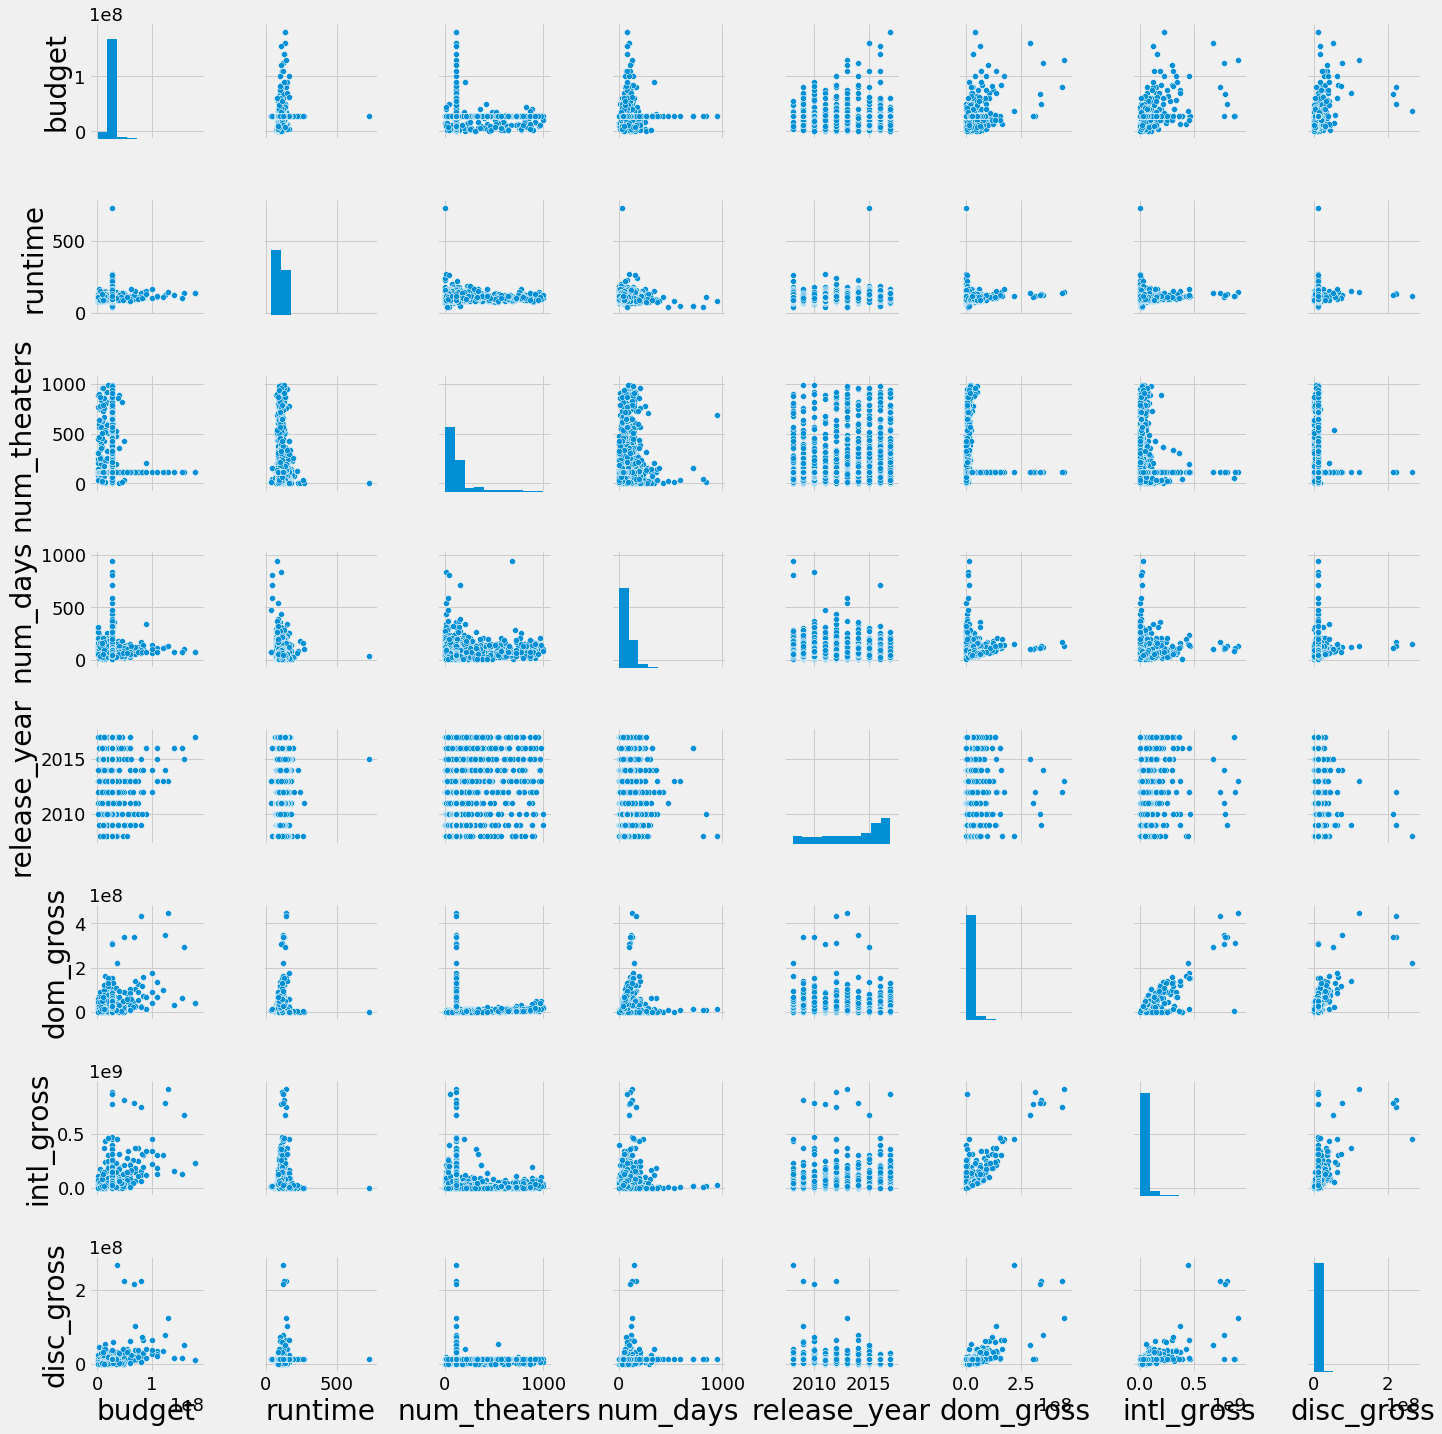

In [11]:
sns.pairplot(df);

# Pre-processing

## Categorical Data
Encode categorical features as sparse matrix of categorical labels.

In [12]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,genre_Action,genre_Action / Adventure,genre_Action / Crime,genre_Action Comedy,genre_Action Drama,genre_Action Fantasy,genre_Action Horror,genre_Action Thriller,genre_Adventure,genre_Adventure Comedy,...,release_month_December,release_month_February,release_month_January,release_month_July,release_month_June,release_month_March,release_month_May,release_month_November,release_month_October,release_month_September
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Log-transformation of Numeric Data
Data is not normally distributed - try transforming to log scale

In [13]:
# transform all feature variables
# X_num = np.log(X_num)

In [14]:
# transform target variable
y = np.log(y)

## Combine Categorical and Numeric Data

In [15]:
X = pd.concat([X_num, X_cat_enc], axis=1)
X.head()

,budget,runtime,num_theaters,num_days,release_year,genre_Action,genre_Action / Adventure,genre_Action / Crime,genre_Action Comedy,genre_Action Drama,...,release_month_December,release_month_February,release_month_January,release_month_July,release_month_June,release_month_March,release_month_May,release_month_November,release_month_October,release_month_September
0,27546069.0,89.0,42.0,196.0,2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,27546069.0,98.0,215.0,76.0,2017,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,27546069.0,125.0,115.0,80.0,2017,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,27546069.0,104.0,13.0,136.0,2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,18000000.0,117.0,331.0,70.0,2017,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initial Modeling

In [17]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('model', LinearRegression())
])

In [18]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.3415934321321942

In [19]:
# cross-validated score
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

-4.054070861829666e+20

**Very low cross-validated R-squared value**

R-squared: 0.2784398674941274


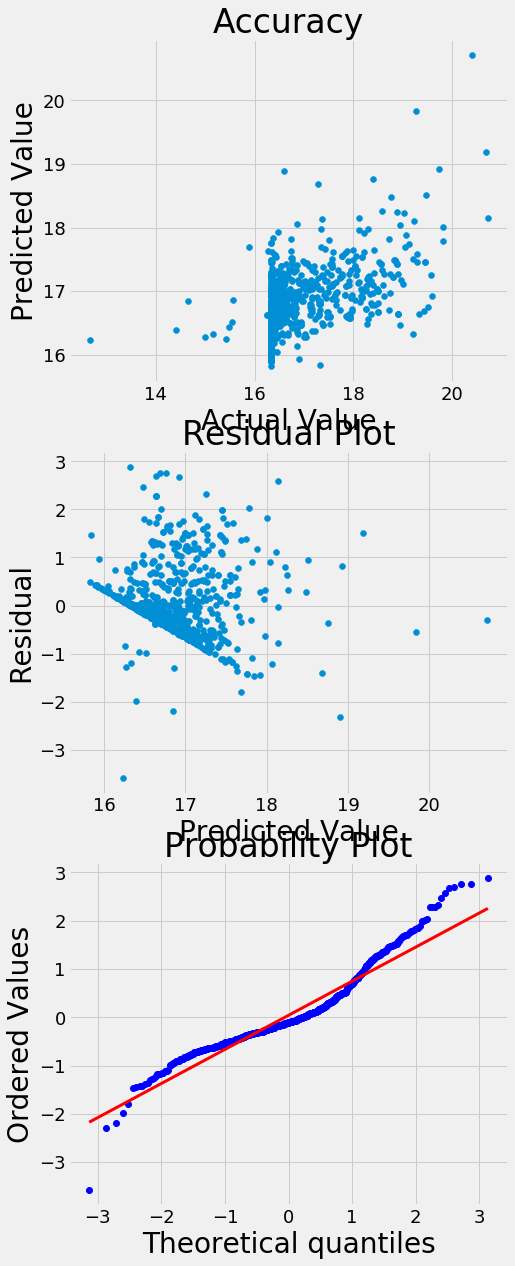

In [20]:
# plots for model evaluation
lr_eval(lr_pipe, X_test, y_test)

**Non-normal distribution of residuals  
Bowing displayed in probability plot**

# Refined Modeling
Fit of model to data may be improved by adding polynomial features. These features will capture interaction between feature variables.

In [21]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.6935185013036117

**Significant increase in model train score**

In [22]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

-1.4355705957048051e+23

**Train score >> cross-validated score  
Model is overfit  
Regularization may help**

R-squared: -4.2300009570020966e+23


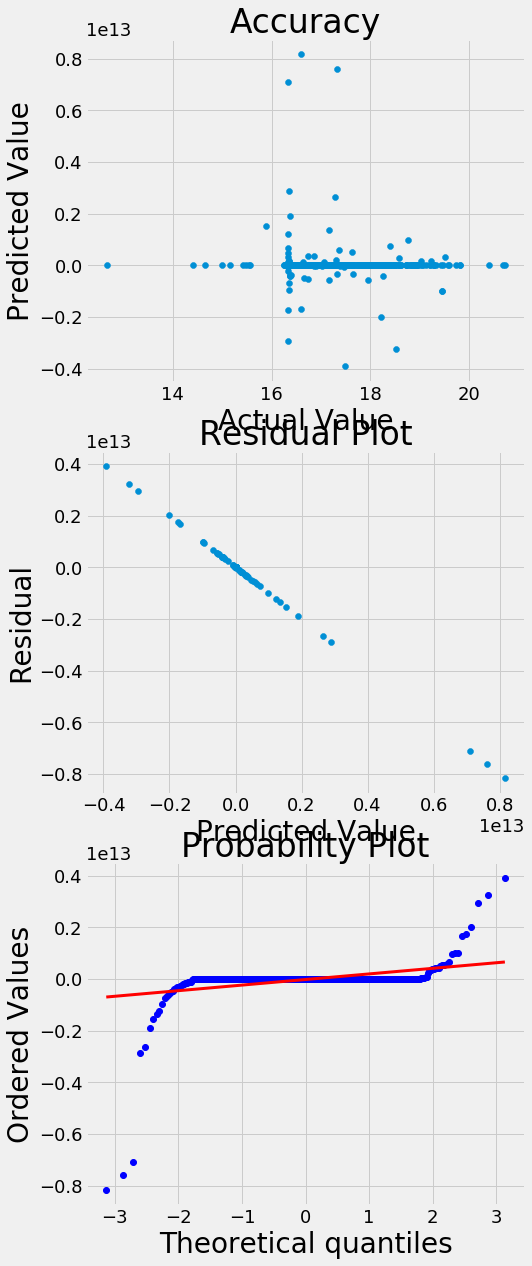

In [23]:
lr_eval(lr_pipe, X_test, y_test)

**Residual plot showing non-normal distribution  
Probability plot has a poor fit**

# Regularization

In [24]:
# range of values for regularization coefficients
alpha_range = alpha_range = np.linspace(0.001, 10, 10)

In [25]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', linear_model.RidgeCV(alphas=alpha_range, cv=5))
])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.585772611608155

In [26]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

0.4096425187686689

R-squared: 0.3995609995589523


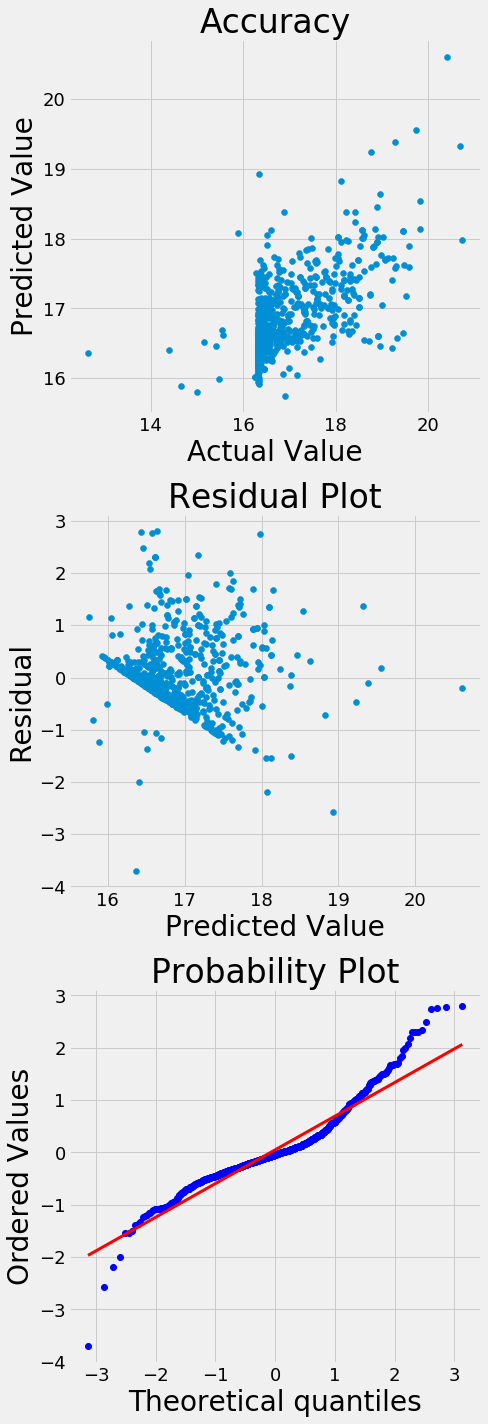

In [34]:
lr_eval(lr_pipe, X_test, y_test)

**Significant improvement in R-squared  
Probability plot has an improved fit**

# Model Interpretation

In [28]:
# polynomial feature labels
feature_labels = lr_pipe.named_steps['poly'].get_feature_names(X.columns)

In [29]:
# model coefficients
coefs = lr_pipe.named_steps['model'].coef_

In [30]:
# sort features by weight
lr_coef = feat_sort(coefs, feature_labels)[0:10]
lr_coef

,feat_wgt,positive
num_days,1.457774,True
budget mpaa_rating_R,1.306050,True
num_days mpaa_rating_R,1.297998,True
budget,1.177271,True
runtime,1.169612,True
num_days release_month_November,1.091531,True
num_theaters mpaa_rating_Unrated,1.057287,True
genre_Romance release_month_November,1.026487,True
genre_Musical release_month_December,1.025185,True
num_theaters release_year,0.951858,False


In [31]:
# define labels for interaction features
features = [
    'No. Days and Theat.', 
    'Action in Jul', 
    'Western in Dec',
    'Runtime and PG-13',
    'Musical in Dec',
    'No. Days and Action',
    'Budget and Year',
    'Romance in Nov',
    'Budget and May',
    'Action in Aug'
]

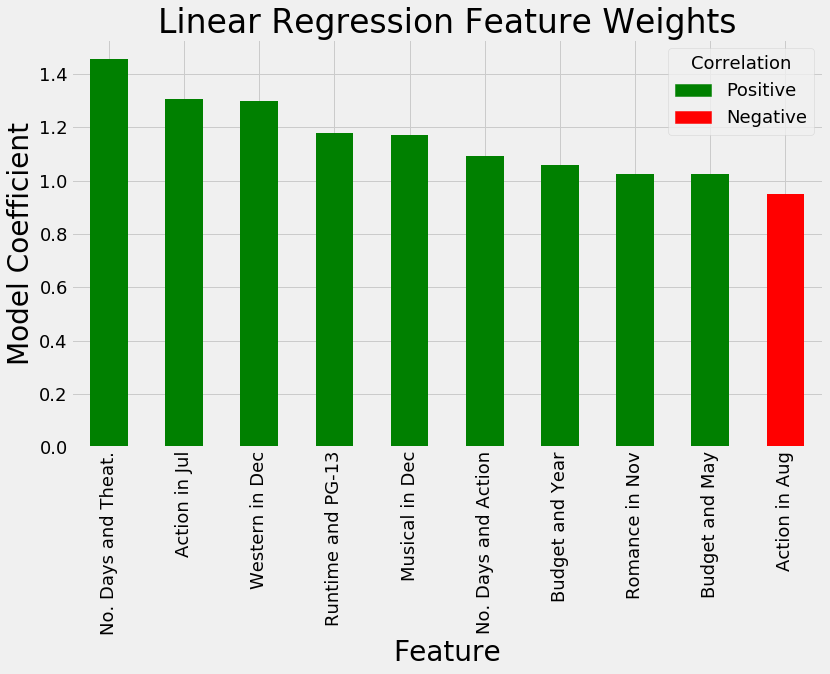

In [49]:
ax = plt.gca()
lr_coef.iloc[:, 0].plot(kind='bar', ax=ax, color=lr_coef.iloc[:, 1].map({True: 'g', False: 'r'}))
ax.set_title('Linear Regression Feature Weights')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Coefficient')
ax.set_xticklabels(features)

pos_patch = mpatches.Patch(color='green', label='Positive')
neg_patch = mpatches.Patch(color='red', label='Negative')
legend = plt.legend(title='Correlation', handles=[pos_patch, neg_patch])
legend.get_title().set_fontsize('18')
# plt.savefig('model_output/lr_feat.png', bbox_inches='tight')